In [1]:
import networkx as nx
import numpy as np
import pandas as pd

def create_tree(current_node, current_depth, max_depth, G):
    if current_depth < max_depth:
        num_children = np.random.randint(1, 6)  # Between 1 and 5 children
        for _ in range(num_children):
            new_node = len(G.nodes)
            G.add_edge(current_node, new_node)
            G.nodes[new_node]['value'] = np.random.random()  # Assign a random floating-point value
            G.nodes[new_node]['depth'] = current_depth + 1  # Set the depth
            create_tree(new_node, current_depth + 1, max_depth, G)

# Number of graphs to generate
num_graphs = 50
# Maximum depth of each tree
max_depth = 4
# Categories for labels
categories = ['DQ_issue', 'RAS']

# List to store the graphs and their labels
graph_data_with_graph_labels = []

# Generate the graphs with global labels
for _ in range(num_graphs):
    G = nx.DiGraph()  # Create a directed graph
    root_node = 0
    G.add_node(root_node)
    G.nodes[root_node]['value'] = np.random.random()
    G.nodes[root_node]['depth'] = 0  # The depth of the root is 0
    create_tree(root_node, 0, max_depth, G)
    
    # Add a global label for the graph
    graph_label = np.random.choice(categories)  # Global categorical label for the graph
    graph_data_with_graph_labels.append((G, graph_label))


C:\Users\decroux paul\AppData\Local\Temp\ipykernel_18028\942329130.py:18: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(tree_to_plot, prog='dot')  # 'dot' is ideal for trees


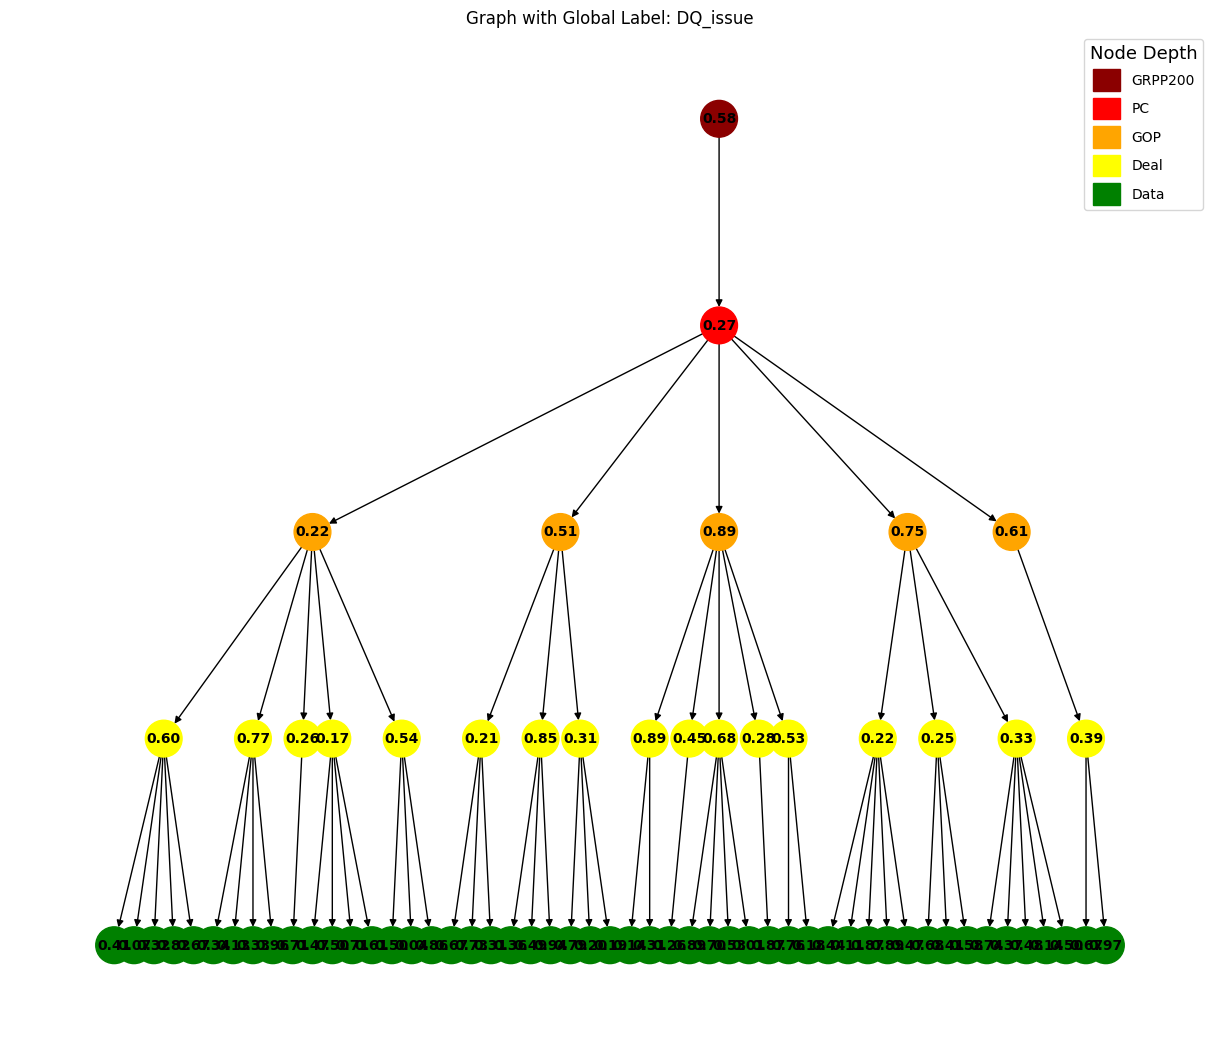

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

# Select the first graph for visualization
tree_to_plot = graph_data_with_graph_labels[1][0]  # Using the second graph in the list

# Calculate colors based on node depth
depth_color = {0: 'darkred', 1: 'red', 2: 'orange', 3: 'yellow', 4: 'green'}
depth_labels = {0: 'GRPP200', 1: 'PC', 2: 'GOP', 3: 'Deal', 4: 'Data'}

# Round floating values and store in a dictionary for display
labels = {node: f"{tree_to_plot.nodes[node]['value']:.2f}" for node in tree_to_plot.nodes()}
node_colors = [depth_color[tree_to_plot.nodes[node]['depth'] % 5] for node in tree_to_plot.nodes()]

# Use graphviz_layout with pydot for tree-like graph layout
pos = graphviz_layout(tree_to_plot, prog='dot')  # 'dot' is ideal for trees

# Draw the graph
plt.figure(figsize=(12, 10))  # Increase figure size for better visibility
nx.draw(tree_to_plot, pos, labels=labels, with_labels=True, node_size=700, node_color=node_colors, font_size=10, font_weight='bold')

# Create a legend for the depth colors with specific labels
legend_handles = [mpatches.Patch(color=color, label=f'{depth_labels[i]}') for i, color in depth_color.items()]
plt.legend(handles=legend_handles, title="Node Depth", title_fontsize='13', handlelength=2, handleheight=2)

plt.title(f"Graph with Global Label: {graph_data_with_graph_labels[0][1]}")
plt.show()


In [3]:
import torch
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, DataLoader



In [4]:
import torch
from torch_geometric.nn import GCNConv, global_mean_pool
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader

# Creating PyTorch Geometric data objects
data_list = []
for tree, label in graph_data_with_graph_labels:
    edge_index = torch.tensor(list(tree.edges()), dtype=torch.long).t().contiguous()
    x = torch.tensor([tree.nodes[n]['value'] for n in tree.nodes()], dtype=torch.float).view(-1, 1)
    y = torch.tensor([categories.index(label)], dtype=torch.long)
    data = Data(x=x, edge_index=edge_index, y=y)
    data_list.append(data)

class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(GCN, self).__init__()
        # Define the first graph convolutional layer
        self.conv1 = GCNConv(num_node_features, 16)
        # Additional layers can be added here, uncomment the following line to add more layers
        self.conv_intermediate = GCNConv(16, 16)  # Example of an additional layer
        
        # Define the second graph convolutional layer, adjust input features if more layers are added
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        # Apply the first convolutional layer and ReLU activation
        x = F.relu(self.conv1(x, edge_index))
        # Uncomment the following line to include the additional layer in the forward pass
        x = F.relu(self.conv_intermediate(x, edge_index))
        
        # Apply dropout for regularization during training
        x = F.dropout(x, p=0.5, training=self.training)
        # Apply the second convolutional layer
        x = self.conv2(x, edge_index)
        # Apply global mean pooling to aggregate node features into a graph-level feature
        x = global_mean_pool(x, batch)  # Aggregate features at the graph level
        return x

# Initialize the model specifying 1 feature per node and the number of classes
model = GCN(num_node_features=1, num_classes=len(categories))


c:\Users\decroux paul\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1, Loss: 0.7024678111076355
Epoch 2, Loss: 0.6933242678642273
Epoch 3, Loss: 0.6919643163681031
Epoch 4, Loss: 0.696276867389679
Epoch 5, Loss: 0.6924610376358032
Epoch 6, Loss: 0.6987059831619262
Epoch 7, Loss: 0.6911686897277832
Epoch 8, Loss: 0.690245795249939
Epoch 9, Loss: 0.6894834637641907
Epoch 10, Loss: 0.6903111577033997
Epoch 11, Loss: 0.6946640014648438
Epoch 12, Loss: 0.6889109134674072
Epoch 13, Loss: 0.688710618019104
Epoch 14, Loss: 0.6878965735435486
Epoch 15, Loss: 0.6923110008239746
Epoch 16, Loss: 0.6870534062385559
Epoch 17, Loss: 0.6820106863975525
Epoch 18, Loss: 0.6882428765296936
Epoch 19, Loss: 0.6854576587677002
Epoch 20, Loss: 0.6853027582168579
Epoch 21, Loss: 0.6842725872993469
Epoch 22, Loss: 0.6819320917129517
Epoch 23, Loss: 0.6783582210540772
Epoch 24, Loss: 0.6816070675849915
Epoch 25, Loss: 0.6786746859550477
Epoch 26, Loss: 0.6816782712936401
Epoch 27, Loss: 0.684746241569519
Epoch 28, Loss: 0.6728595852851867
Epoch 29, Loss: 0.681104624271392

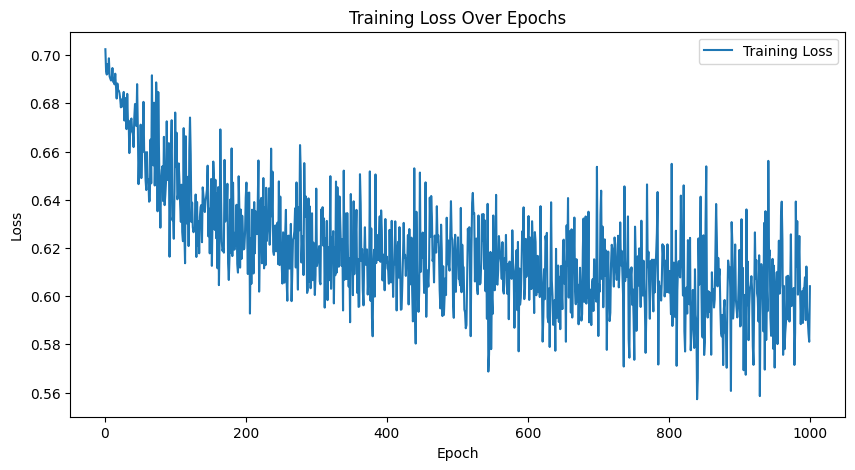

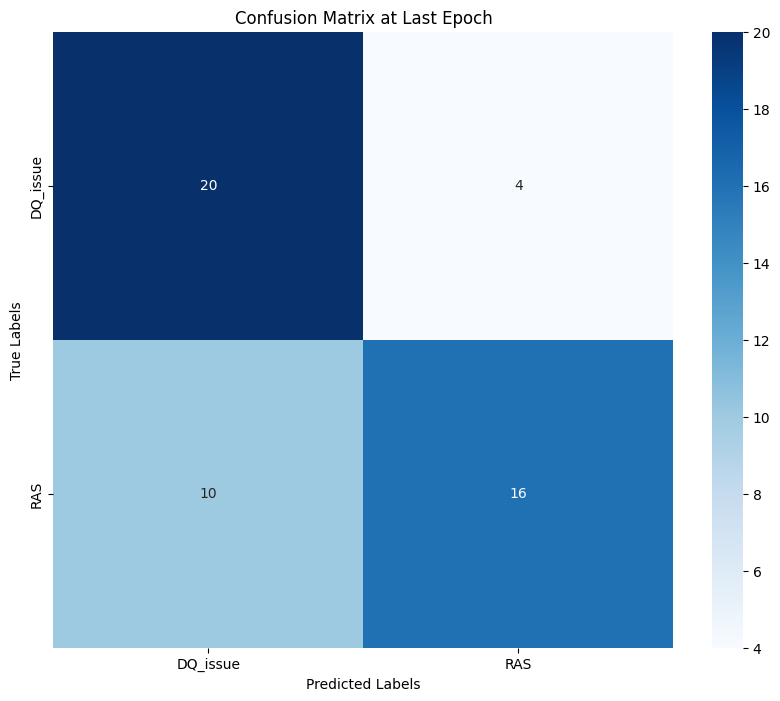

In [5]:
import torch
import matplotlib.pyplot as plt
from torch_geometric.data import DataLoader
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Assuming 'model' and 'data_list' are already defined
# Define the loss criterion and optimizer
criterion = torch.nn.CrossEntropyLoss()  # Loss for classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Optimizer with learning rate

# Prepare the DataLoader
train_loader = DataLoader(data_list, batch_size=10, shuffle=True)

# Training loop
def train():
    model.train()  # Set the model to training mode
    total_loss = 0
    all_preds = []
    all_labels = []
    for data in train_loader:
        optimizer.zero_grad()  # Reset gradients
        out = model(data)  # Pass data through the model
        loss = criterion(out, data.y)  # Calculate loss
        loss.backward()  # Backpropagate gradients
        optimizer.step()  # Update weights
        total_loss += loss.item()
        
        # Store predictions and actual labels for confusion matrix
        _, predicted = torch.max(out, 1)
        all_preds.extend(predicted.view(-1).cpu().numpy())
        all_labels.extend(data.y.view(-1).cpu().numpy())
    
    # Calculate confusion matrix
    conf_mat = confusion_matrix(all_labels, all_preds)
    return total_loss / len(train_loader), conf_mat  # Return average loss and confusion matrix

# Initialize performance metrics
epochs = 1000
losses = []
confusion_matrices = []

# Train for a set number of epochs
for epoch in range(epochs):
    loss, conf_mat = train()
    losses.append(loss)
    confusion_matrices.append(conf_mat)
    print(f'Epoch {epoch+1}, Loss: {loss}')

# Plot loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# Plot the confusion matrix of the last epoch
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrices[-1], annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix at Last Epoch')
plt.show()


In [7]:
model.eval()  # Set the model to evaluation mode

# Select the graph for prediction (here, we are taking the first graph)
data = data_list[0]

# Execute the model on the selected graph to get the prediction
with torch.no_grad():  # Disables gradient computation for prediction
    out = model(data)
    pred_label_idx = out.argmax(dim=1)  # Get the index of the predicted class
    pred_label = categories[pred_label_idx.item()]  # Convert index to label

# Display the prediction
print(f"Actual Label: {categories[data.y.item()]}")
print(f"Predicted Label: {pred_label}")


Actual Label: DQ_issue
Predicted Label: RAS
